In [1]:
import pandas as pd
import numpy as np
from invertiblewavelets import Transform
import matplotlib.pyplot as plt
from invertiblewavelets import *
from scipy import signal

#### Load Example Data from Swarm A Spacecraft Magnetoemter

In [2]:
data = np.load("data.npy")

# Adding some noise
sample_rate = 50.0                          # 50 Hz sampling rate
num_samples = data.shape[-1]                # 5000 samples
t = np.arange(num_samples) / sample_rate    # time array

#### Create Transform Object and Analysis Filters

In [3]:
# Initializing the Transform object automatically forms the analysis and synthesis filter bank during __init__
transform = Transform(
    data=data,
    fs = sample_rate,
    wavelet=Morlet(1,2),
    pad_method='symmetric', # Padding method for the convolution calls np.pad. Set to None if no padding
    Mc = 1,
)
transform.enforce_orthagonality(eps=1e-3)

Text(0.5, 0, 'Frequency Channel')

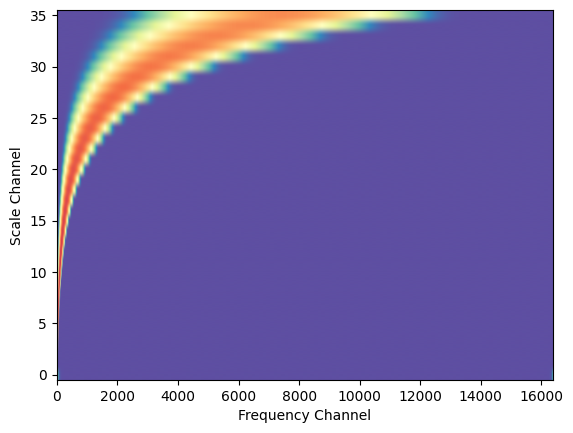

In [4]:
fig, ax = plt.subplots(1,1)
ax.imshow(np.log(np.abs(transform.Wfreq)+1e-3), aspect='auto', origin='lower', cmap='Spectral_r', interpolation=None)
ax.set_ylabel('Scale Channel')
ax.set_xlabel('Frequency Channel')

#### Transform and Inverse the Data

Reconstruction error: 0.0002765698970089492


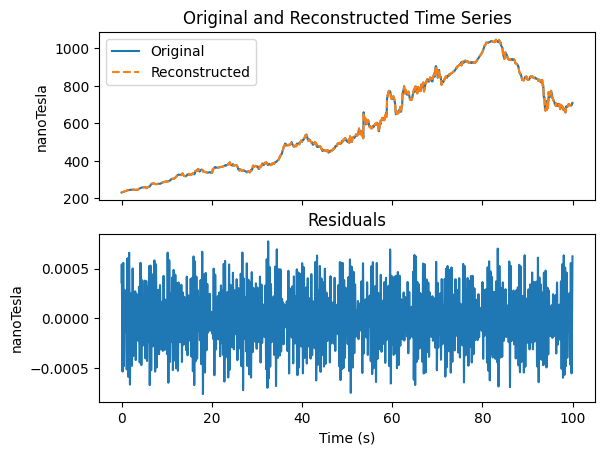

In [7]:
# Perform forward wavelet transform
coefficients = transform.forward(data)

# Perform inverse wavelet transform (reconstruction)
reconstructed = transform.inverse(coefficients)

# Calculate and print reconstruction error
reconstruction_error = np.sqrt(np.mean((reconstructed - data)**2))
print(f"Reconstruction error: {reconstruction_error}")

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(t, data, label='Original')
ax[0].plot(t, reconstructed, label='Reconstructed', linestyle='--')    
ax[0].set_ylabel('nanoTesla')
ax[0].legend()
ax[0].set_title('Original and Reconstructed Time Series')
ax[1].plot(t, data - reconstructed)
ax[1].set_title('Residuals')
ax[1].set_ylabel('nanoTesla')
ax[1].set_xlabel('Time (s)')
plt.show()

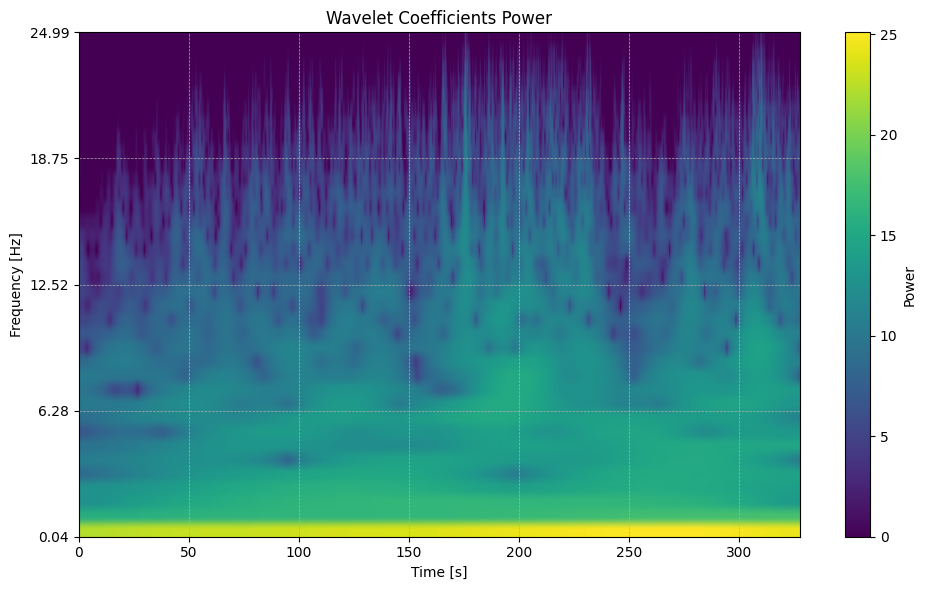

In [8]:
transform.scalogram(coefficients, vmin=0)

#### Check the wavelet spectral coverage

#### Check Wavelet Orthgonality

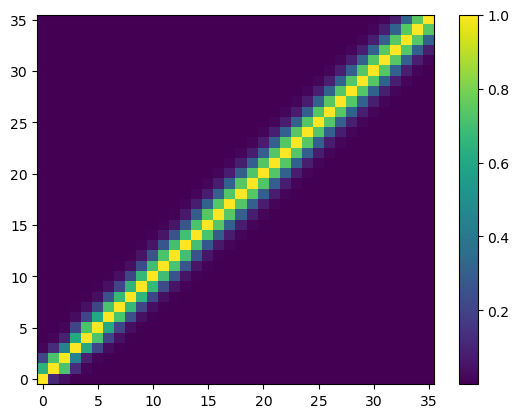

In [53]:
w_time = np.fft.ifft(transform.Wfreq, axis=-1)
delta_kl = w_time.conj() @ w_time.T
delta_kl = delta_kl / np.max(delta_kl, axis=1)[:, np.newaxis]
plt.imshow(np.abs(delta_kl), aspect='auto', origin='lower')
cbar = plt.colorbar()

#### Check Spectral Leakage

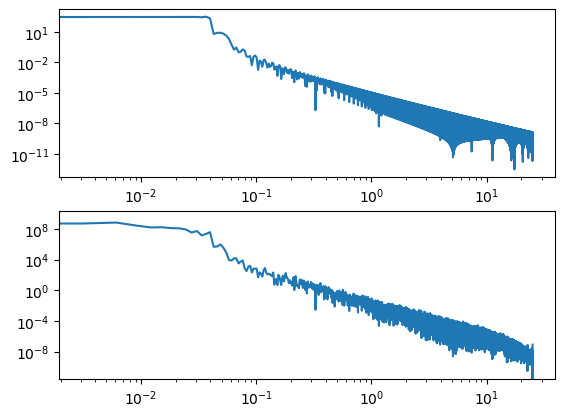

In [54]:
fig, ax = plt.subplots(2,1)
i = 0
N = coefficients.shape[-1]
freqs = np.fft.fftfreq(N, d=1/sample_rate)
ax[0].plot(freqs[:N//2], np.abs(transform.Wfreq[i][:N//2]))
ax[1].plot(freqs[:N//2], np.abs(np.fft.fft(coefficients, axis=1))[i][:N//2])
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_xscale('log')
ax[1].set_xscale('log')